# 1. Filtering Operations & Point Cloud Creation

The following notebook intends on demonstrating the process to create a point-cloud extracted from a scene recorded by the Azure Kinect. 

## 1. Importing the libraries

In [22]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import trimesh
%matplotlib inline

## 2. Loading the images

In [23]:
rgb_image_path = "/home/roli_005/TE3002B_ws/src/module_munoz/3D-SemiDeformable-ObjectTracking/Reference Notebooks/resources/ImagesAndPointClouds/color/00000.jpg"
depth_image_path = "/home/roli_005/TE3002B_ws/src/module_munoz/3D-SemiDeformable-ObjectTracking/Reference Notebooks/resources/ImagesAndPointClouds/depth/00000.png"

rgb_image =   cv2.imread(rgb_image_path)
depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED) 

check the depth image is in the right format: 

In [24]:
if depth_image.dtype == np.uint16 and len(depth_image.shape) == 2:
    print("The depth image is a 16-bit single-channel image.")
else:
    print("The depth image is not in the expected format.")

The depth image is a 16-bit single-channel image.


Display the images using matplotlib

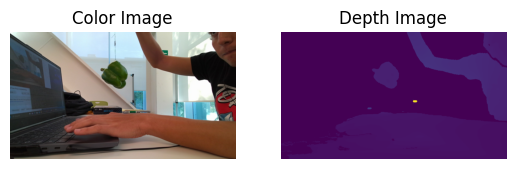

In [25]:
plt.subplot(1,2,1)
plt.title("Color Image")
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Depth Image")
plt.imshow(depth_image)
plt.axis("off")
plt.show()

## 3. Filtering the images

### Color Filtering

**Color Mask Parameters**

The following are the parameters that work with the demo image. In case you need to change them, you can uncomment the functions that have to do with color and depth filtering which appear commented in this notebook. They are currently filtering the color green. They are intended to be used with an HSV image for color filtering, creating a mask. 

In [26]:
# Filtering by color (HSV): 
lower_green = np.array([18, 7, 30])
upper_green = np.array([84, 255, 138])
# hsv image
hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2HSV)
# color mask 
green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

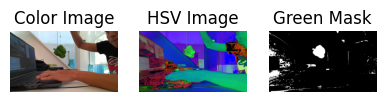

In [27]:
plt.subplot(1,4,1)
plt.title("Color Image")
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
# -----------------------
plt.subplot(1,4,2)
plt.title("HSV Image") 
plt.imshow(hsv_image) 
plt.axis("off")
# Note: the values for the hsv image aren't necessarily 1:1
# to how they appear in OpenCV, the image is not modified in the
# matplotlib visualization just to show the color differences. 
# -----------------------
plt.subplot(1,4,3)
plt.title("Green Mask")
plt.imshow(green_mask, cmap='gray')
plt.axis("off")
plt.show()

In [28]:
result = cv2.bitwise_and(rgb_image, rgb_image, mask=green_mask)

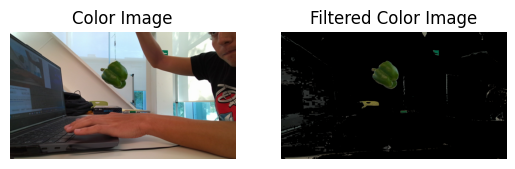

In [29]:
plt.subplot(1,2,1)
plt.title("Color Image")
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Filtered Color Image")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### Depth Filtering

You can filter using depth-levels. Just as with the color filtering, you can choose what part of the depth image you keep, now keeping pixels with a certain depth-level data. The included values are the ones that work with this image, but there is also a function that you can use in order to obtain new depth threshold values.  

In [30]:
lower_depth_bound = 350
upper_depth_bound = 525
depth_mask = cv2.inRange(depth_image, 350, 525)

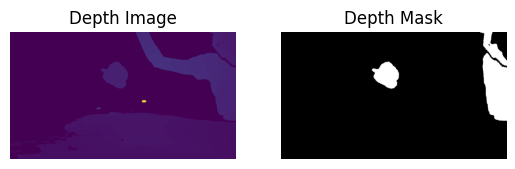

In [31]:
plt.subplot(1,2,1)
plt.title("Depth Image")
plt.imshow(depth_image)
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Depth Mask")
plt.imshow(depth_mask, cmap='gray')
plt.axis("off")
plt.show()

### Combining the masks

Once you have both masks, you combine them in order to create a more refined mask, keeping only the elements that are present in both masks. 

In [32]:
combined_mask = cv2.bitwise_and(green_mask, depth_mask)

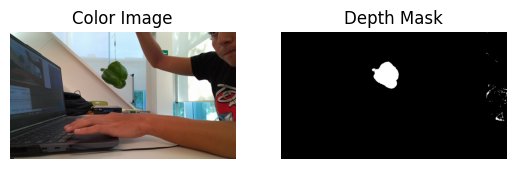

In [33]:
plt.subplot(1,2,1)
plt.title("Color Image")
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Depth Mask")
plt.imshow(combined_mask, cmap='gray')
plt.axis("off")
plt.show()

### Calculating the connected components

Once you have successfully combined the masks, you get an almost clean result, but some noise still exists in the image. This can be fixed by considering the connected components in the image. Filtering by extracting connected components allows us to get important information of objects in the image, knowing information such as their centroids, area and Hu moments. 

In [34]:
# Compute connected components
num_lablels, labels, stats, centroids = cv2.connectedComponentsWithStats(combined_mask, 8, cv2.CV_32S)
# Find largest component
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
# Create a Mask of the largest component
cleaned_mask = np.where(labels == largest_label, 255, 0).astype('uint8')

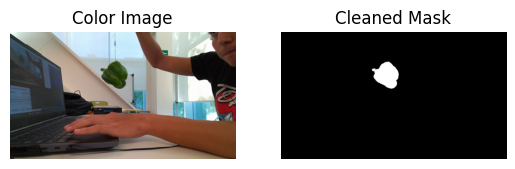

In [35]:
plt.subplot(1,2,1)
plt.title("Color Image")
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Cleaned Mask")
plt.imshow(cleaned_mask, cmap='gray')
plt.axis("off")
plt.show()

This leaves us with a clean bell pepper mask, which we can then use on the depth and color images in order to just keep the information of the bell pepper. 

In [36]:
result_rgb = cv2.bitwise_and(rgb_image, rgb_image, mask=cleaned_mask)
result_depth = cv2.bitwise_and(depth_image, depth_image, mask= cleaned_mask)

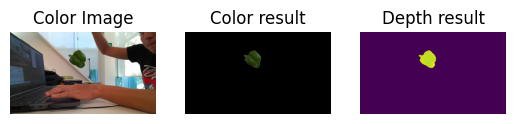

In [37]:
plt.subplot(1,3,1)
plt.title("Color Image")
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1,3,2)
plt.title("Color result")
plt.imshow(cv2.cvtColor(result_rgb, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1,3,3)
plt.title("Depth result")
plt.imshow(result_depth)
plt.axis("off")
plt.show()

## 4. Depth Image Creation

Using both the color images and depth images as well as the intrinsic information of the kinect camera we can now make an RGB-D image and extract a point cloud from it. 

**Camera Intrinsics**

In [38]:
# Load camera images

import json
# Load camera intrinsics
with open("/home/roli_005/TE3002B_ws/src/module_munoz/3D-SemiDeformable-ObjectTracking/Reference Notebooks/intrinsic.json", 'r') as f:
    intrinsic_json = json.load(f)

# Convert flat list to 3x3 nested list
intrinsic_matrix_flat = intrinsic_json['intrinsic_matrix']
intrinsic_matrix = [
    intrinsic_matrix_flat[0:3],
    intrinsic_matrix_flat[3:6],
    intrinsic_matrix_flat[6:9],
]

# Create PinholeCameraIntrinsic object
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    intrinsic_json['width'],
    intrinsic_json['height'],
    intrinsic_matrix[0][0],  # fx
    intrinsic_matrix[1][1],  # fy
    intrinsic_matrix[0][2],  # cx
    intrinsic_matrix[1][2],  # cy
)

**RGB-D Image Creation**

In [39]:
o3d_color = o3d.geometry.Image(result_rgb)
o3d_depth = o3d.geometry.Image(result_depth)

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(o3d_color, o3d_depth, convert_rgb_to_intensity=False)
print(rgbd_image)

RGBDImage of size 
Color image : 1280x720, with 3 channels.
Depth image : 1280x720, with 1 channels.
Use numpy.asarray to access buffer data.


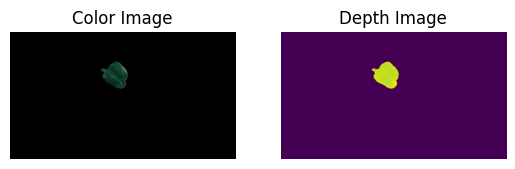

In [40]:
# Plot the images
plt.subplot(1,2,1)
plt.title('Color Image')
plt.imshow(rgbd_image.color, cmap='gray')
plt.axis("off")
plt.subplot(1,2,2)
plt.title('Depth Image')
plt.imshow(rgbd_image.depth)
plt.axis("off")
plt.show()

## 5. Point Cloud generation

In [41]:
# Create the point cloud from images and camera intrinsic parameters
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
pcd.transform([[1,0,0,0], [0,-1,0,0], [0,0,-1,0], [0,0,0,1]])

PointCloud with 15200 points.

In [42]:
# o3d.io.write_point_cloud("/home/roli_005/TE3002B_ws/src/module_munoz/3D-SemiDeformable-ObjectTracking/Reference Notebooks/resources/ImagesAndPointClouds/pointcloud/new_pc/01_color.ply", pcd)
o3d.visualization.draw_geometries([pcd])

After this step the point cloud has been generated and you can now move on to the next notebook: "create_pc_from_mesh.ipynb"